In [4]:
pip install plotly

     |████████████████████████████████| 13.2MB 240kB/s eta 0:00:01     |██████████████████████████▋     | 11.0MB 1.4MB/s eta 0:00:02
  Running setup.py install for retrying ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install missingno

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

In [7]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql import types

In [8]:
sparkConf = SparkConf()

sparkConf.setAppName("spark")

DRIVER_MEM = "6g"
# sparkConf.set("spark.driver.memory", DRIVER_MEM)

spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()
sc = spark.sparkContext

age
sex: sex (1 = male; 0 = female)
cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
trestbps: resting blood pressure (in mm Hg on admission to the 
        hospital)
12 chol: serum cholestoral in mg/dl
16 fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
19 restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
                    elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy
                    by Estes' criteria
32 thalach: maximum heart rate achieved
38 exang: exercise induced angina (1 = yes; 0 = no)
     40 oldpeak = ST depression induced by exercise relative to rest
41 slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping

 44 ca: number of major vessels (0-3) colored by flourosopy

 51 thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
 58 num: diagnosis of heart disease (angiographic disease status)
    -- Value 0: < 50% diameter narrowing
    -- Value 1: > 50% diameter narrowing
    (in any major vessel: attributes 59 through 68 are vessels)


In [9]:
df = spark.read.csv('processed.cleveland.data', inferSchema=True, header=True)

In [10]:
df.show(5)

+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---+
| age|sex| cp|trestbps| chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|num|
+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---+
|63.0|1.0|1.0|   145.0|233.0|1.0|    2.0|  150.0|  0.0|    2.3|  3.0|0.0| 6.0|  0|
|67.0|1.0|4.0|   160.0|286.0|0.0|    2.0|  108.0|  1.0|    1.5|  2.0|3.0| 3.0|  2|
|67.0|1.0|4.0|   120.0|229.0|0.0|    2.0|  129.0|  1.0|    2.6|  2.0|2.0| 7.0|  1|
|37.0|1.0|3.0|   130.0|250.0|0.0|    0.0|  187.0|  0.0|    3.5|  3.0|0.0| 3.0|  0|
|41.0|0.0|2.0|   130.0|204.0|0.0|    2.0|  172.0|  0.0|    1.4|  1.0|0.0| 3.0|  0|
+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---+
only showing top 5 rows



In [11]:
df.head(2)

[Row(age=63.0, sex=1.0, cp=1.0, trestbps=145.0, chol=233.0, fbs=1.0, restecg=2.0, thalach=150.0, exang=0.0, oldpeak=2.3, slope=3.0, ca='0.0', thal='6.0', num=0),
 Row(age=67.0, sex=1.0, cp=4.0, trestbps=160.0, chol=286.0, fbs=0.0, restecg=2.0, thalach=108.0, exang=1.0, oldpeak=1.5, slope=2.0, ca='3.0', thal='3.0', num=2)]

In [12]:
df.printSchema()

root
 |-- age: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- cp: double (nullable = true)
 |-- trestbps: double (nullable = true)
 |-- chol: double (nullable = true)
 |-- fbs: double (nullable = true)
 |-- restecg: double (nullable = true)
 |-- thalach: double (nullable = true)
 |-- exang: double (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: double (nullable = true)
 |-- ca: string (nullable = true)
 |-- thal: string (nullable = true)
 |-- num: integer (nullable = true)



In [13]:
df.count(),len(df.columns)

(313, 14)

In [14]:
df.summary().show()

+-------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              age|               sex|                cp|          trestbps|             chol|                fbs|           restecg|           thalach|              exang|           oldpeak|             slope|                ca|              thal|               num|
+-------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|  count|              313|               313|               313|               313|              313|                313|               313|               313|            

### Remove Duplicate Rows

In [15]:
df_d = df.distinct()

### Get Summary of data

In [16]:
df_d.summary().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              age|               sex|                cp|          trestbps|              chol|                fbs|           restecg|           thalach|             exang|           oldpeak|             slope|                ca|              thal|               num|
+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|              304|               304|               304|               304|               304|                304|               304|               304|           

In [17]:
df_d.dtypes

[('age', 'double'),
 ('sex', 'double'),
 ('cp', 'double'),
 ('trestbps', 'double'),
 ('chol', 'double'),
 ('fbs', 'double'),
 ('restecg', 'double'),
 ('thalach', 'double'),
 ('exang', 'double'),
 ('oldpeak', 'double'),
 ('slope', 'double'),
 ('ca', 'string'),
 ('thal', 'string'),
 ('num', 'int')]

### Check how many unique values per column

In [18]:
pd_df = df.toPandas()

In [19]:
pd_df.nunique()

age          42
sex           2
cp            4
trestbps     50
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
num           5
dtype: int64

In [20]:
list_of_nunique = [f.countDistinct(c) for c in df_d.columns]
df_d.select(list_of_nunique).show()

+-------------------+-------------------+------------------+------------------------+--------------------+-------------------+-----------------------+-----------------------+---------------------+-----------------------+---------------------+------------------+--------------------+-------------------+
|count(DISTINCT age)|count(DISTINCT sex)|count(DISTINCT cp)|count(DISTINCT trestbps)|count(DISTINCT chol)|count(DISTINCT fbs)|count(DISTINCT restecg)|count(DISTINCT thalach)|count(DISTINCT exang)|count(DISTINCT oldpeak)|count(DISTINCT slope)|count(DISTINCT ca)|count(DISTINCT thal)|count(DISTINCT num)|
+-------------------+-------------------+------------------+------------------------+--------------------+-------------------+-----------------------+-----------------------+---------------------+-----------------------+---------------------+------------------+--------------------+-------------------+
|                 42|                  2|                 4|                      50|      

### Validate columns that have bad data

In [21]:
df_d.select('ca').distinct().show()

+---+
| ca|
+---+
|1.0|
|0.0|
|2.0|
|  ?|
|3.0|
+---+



In [22]:
df_d.groupBy('ca').count().show()

+---+-----+
| ca|count|
+---+-----+
|1.0|   65|
|0.0|  176|
|2.0|   38|
|  ?|    5|
|3.0|   20|
+---+-----+



In [23]:
df_d.where(f.col('ca') == '?').show()

+------+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---+
|   age|sex| cp|trestbps| chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|num|
+------+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---+
|  38.0|1.0|3.0|   138.0|175.0|0.0|    0.0|  173.0|  0.0|    0.0|  1.0|  ?| 3.0|  0|
|  58.0|1.0|2.0|   125.0|220.0|0.0|    0.0|  144.0|  0.0|    0.4|  2.0|  ?| 7.0|  0|
|  43.0|1.0|4.0|   132.0|247.0|1.0|    2.0|  143.0|  1.0|    0.1|  2.0|  ?| 7.0|  1|
|1000.0|1.0|3.0|   138.0|175.0|0.0|    0.0|  173.0|  0.0|    0.0|  1.0|  ?| 3.0|  0|
|  52.0|1.0|3.0|   138.0|223.0|0.0|    0.0|  169.0|  0.0|    0.0|  1.0|  ?| 3.0|  0|
+------+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---+



In [24]:
df_d = df_d.replace("?", None, subset = "ca")
df_d.groupby('ca').count().show()

+----+-----+
|  ca|count|
+----+-----+
| 1.0|   65|
|null|    5|
| 0.0|  176|
| 2.0|   38|
| 3.0|   20|
+----+-----+



In [25]:
df_d = df_d.replace("?",None,subset="thal")
df_d.groupby("thal").count().show()

+----+-----+
|thal|count|
+----+-----+
|null|    2|
| 6.0|   18|
| 7.0|  117|
| 3.0|  167|
+----+-----+



### Find Null counts

#### List Comprehension

In [26]:
list_col = [f.count(f.when(f.col(c).isNull(),c)).alias(c) for c in df_d.columns]

df_d.select(list_col).show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+---+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|num|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+---+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  5|   2|  0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+---+



#### Map

In [27]:
def get_null_cnt(c):
    return f.count(f.when(f.col(c).isNull(),c)).alias(c)

map_of_nulls = map(get_null_cnt, df_d.columns )
list_null_cnt = list(map_of_nulls)

df_d.select(list_null_cnt).show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+---+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|num|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+---+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  5|   2|  0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+---+



### Get condition counts for all columns: check 0 values

In [28]:
def get_null_cnt(c):
    return f.count(f.when(f.col(c) == '0',c)).alias(c)

map_of_nulls = map(get_null_cnt, df_d.columns )
list_null_cnt = list(map_of_nulls)

df_d.select(list_null_cnt).show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+---+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|num|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+---+
|  0| 97|  0|       0|   0|259|    152|      0|  205|    100|    0|  0|   0|165|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+---+



### Fill nulls with Median

In [29]:
df_d = df_d.withColumn('ca', f.col('ca').cast(types.IntegerType()))

ca_median = df_d.approxQuantile("ca", [0.5], 0.25)

df_d = df_d.na.fill(ca_median[0])

########################################

df_d = df_d.withColumn('thal', f.col('thal').cast(types.IntegerType()))

thal_median = df_d.approxQuantile("thal", [0.5], 0.25)

df_d = df_d.na.fill(thal_median[0])

########################################

list_col = [f.count(f.when(f.col(c).isNull(),c)).alias(c) for c in df_d.columns]

df_d.select(list_col).show()


+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+---+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|num|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+---+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|  0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+---+



### Get Mean for filling

In [33]:
df_d.select('ca').agg(f.avg("ca")).collect()[0][0]

# df_d = df_d.replace(None,f.mean())

0.6611842105263158

### Get summary again

In [34]:
df_d.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|              age|               sex|                cp|          trestbps|              chol|                fbs|           restecg|           thalach|             exang|           oldpeak|             slope|                ca|             thal|               num|
+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|              304|               304|               304|               304|               304|                304|               304|               304|              

### Replace features with names for easier to understand plots

In [35]:
df_p = df_d

df_p = df_p.withColumn('target',f.col('num').cast("string"))
df_p = df_p.replace(['1','2','3','4'],"Disease", subset='target')
df_p = df_p.replace('0',"No_Disease", subset='target')

df_p = df_p.withColumn('sex',f.col('sex').cast('string'))
df_p = df_p.replace({'1.0': "Male", '0.0': "Female"}, subset='sex')

df_p = df_p.withColumn('cp', f.col('cp').cast('string'))
df_p = df_p.replace({'2.0': "atypical_angina", '1.0': 'typical_angina', '3.0': 'non-anginal pain', '4.0': 'asymptomatic'},
            subset='cp')

df_p = df_p.withColumn('exang', f.col('exang').cast('string'))
df_p = df_p.replace({'0.0': 'True', '1.0': 'False'}, subset = 'exang')

df_p = df_p.withColumn('fbs', f.col('fbs').cast('string'))
df_p = df_p.replace({'0.0': 'True', '1.0': 'False'}, subset = 'fbs')

df_p = df_p.withColumn('slope', f.col('slope').cast('string'))
df_p = df_p.replace({'1.0': 'upsloping', '2.0': 'flat', '3.0': 'downsloping'}, subset = 'slope')

df_p = df_p.withColumn('thal', f.col('thal').cast('string'))
df_p = df_p.replace({'3': 'fixed_defect', '6': 'fixed_defect', '7': "reversable_defect"}, subset = 'thal')

df_p.show()

df_p.dtypes


+----+------+----------------+--------+-----+-----+-------+-------+-----+-------+-----------+---+-----------------+---+----------+
| age|   sex|              cp|trestbps| chol|  fbs|restecg|thalach|exang|oldpeak|      slope| ca|             thal|num|    target|
+----+------+----------------+--------+-----+-----+-------+-------+-----+-------+-----------+---+-----------------+---+----------+
|71.0|Female|non-anginal pain|   110.0|265.0|False|    2.0|  130.0| True|    0.0|  upsloping|  1|     fixed_defect|  0|No_Disease|
|42.0|  Male|non-anginal pain|   120.0|240.0|False|    0.0|  194.0| True|    0.8|downsloping|  0|reversable_defect|  0|No_Disease|
|34.0|Female| atypical_angina|   118.0|210.0| True|    0.0|  192.0| True|    0.7|  upsloping|  0|     fixed_defect|  0|No_Disease|
|64.0|  Male|    asymptomatic|   120.0|246.0| True|    2.0|   96.0|False|    2.2|downsloping|  1|     fixed_defect|  3|   Disease|
|70.0|  Male|    asymptomatic|   145.0|174.0| True|    0.0|  125.0|False|    2.6|do

[('age', 'double'),
 ('sex', 'string'),
 ('cp', 'string'),
 ('trestbps', 'double'),
 ('chol', 'double'),
 ('fbs', 'string'),
 ('restecg', 'double'),
 ('thalach', 'double'),
 ('exang', 'string'),
 ('oldpeak', 'double'),
 ('slope', 'string'),
 ('ca', 'int'),
 ('thal', 'string'),
 ('num', 'int'),
 ('target', 'string')]

### Find Outliers

In [36]:
pd_df = df_d.toPandas()

age            AxesSubplot(0.125,0.536818;0.0945122x0.343182)
sex         AxesSubplot(0.238415,0.536818;0.0945122x0.343182)
cp          AxesSubplot(0.351829,0.536818;0.0945122x0.343182)
trestbps    AxesSubplot(0.465244,0.536818;0.0945122x0.343182)
chol        AxesSubplot(0.578659,0.536818;0.0945122x0.343182)
fbs         AxesSubplot(0.692073,0.536818;0.0945122x0.343182)
restecg     AxesSubplot(0.805488,0.536818;0.0945122x0.343182)
thalach           AxesSubplot(0.125,0.125;0.0945122x0.343182)
exang          AxesSubplot(0.238415,0.125;0.0945122x0.343182)
oldpeak        AxesSubplot(0.351829,0.125;0.0945122x0.343182)
slope          AxesSubplot(0.465244,0.125;0.0945122x0.343182)
ca             AxesSubplot(0.578659,0.125;0.0945122x0.343182)
thal           AxesSubplot(0.692073,0.125;0.0945122x0.343182)
num            AxesSubplot(0.805488,0.125;0.0945122x0.343182)
dtype: object

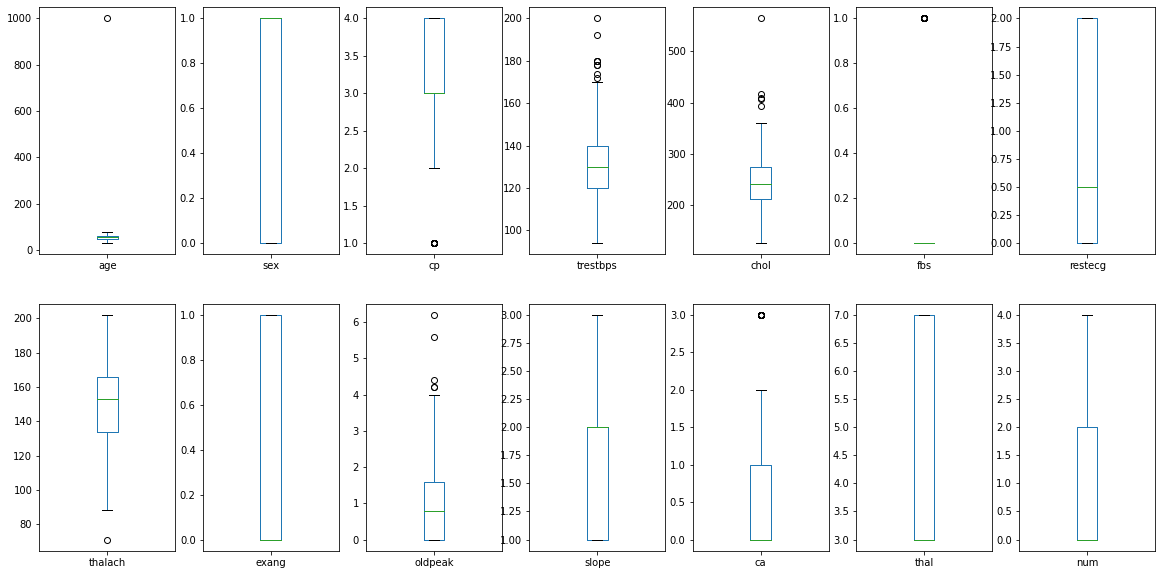

In [37]:
pd_df.plot(kind='box', subplots='True',layout=(2,7),sharex=False,sharey=False, figsize=(20, 10))

In [39]:
# fig = px.box(pd_df, x='target', y='chol')
# fig.show()

<AxesSubplot:xlabel='target', ylabel='chol'>

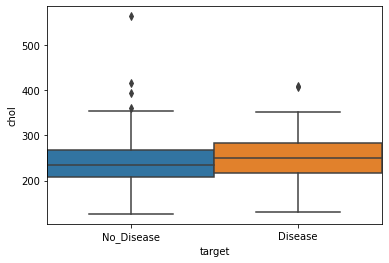

In [40]:
pd_df = df_p.toPandas()
sns.boxplot(x='target',y='chol',data=pd_df,width=1)

#### Create the IQR bounds
https://blog.zhaytam.com/2019/07/15/outliers-detection-in-pyspark-2-interquartile-range/

In [41]:
## demonstrate Zip an list comprehensions. Curly's used for dictionary, c is first element : second element
## in this case the second element is going to be a list of the bounds calculated by approxQuantile.
## Use if statements to get only the numerical datatypes
{c: d for c,d in zip(df_p.columns,df_p.dtypes) if (d[1] == 'double' or d[1] == 'int') }

{'age': ('age', 'double'),
 'trestbps': ('trestbps', 'double'),
 'chol': ('chol', 'double'),
 'restecg': ('restecg', 'double'),
 'thalach': ('thalach', 'double'),
 'oldpeak': ('oldpeak', 'double'),
 'ca': ('ca', 'int'),
 'num': ('num', 'int')}

In [42]:
### Dictionary Method: create a dictionary of dictionaries for nested addressing later. More complex but better
### Var naming
dict_bounds = {c: dict(zip(['q1','q3'],df_p.approxQuantile(c,[0.25,.75],0)))
          for c,d in zip(df_p.columns,df_p.dtypes) if (d[1] == 'double' or d[1] == 'int') }
dict_bounds

{'age': {'q1': 48.0, 'q3': 61.0},
 'trestbps': {'q1': 120.0, 'q3': 140.0},
 'chol': {'q1': 211.0, 'q3': 275.0},
 'restecg': {'q1': 0.0, 'q3': 2.0},
 'thalach': {'q1': 133.0, 'q3': 166.0},
 'oldpeak': {'q1': 0.0, 'q3': 1.6},
 'ca': {'q1': 0.0, 'q3': 1.0},
 'num': {'q1': 0.0, 'q3': 2.0}}

In [43]:
for c in dict_bounds:
    iqr = dict_bounds[c]['q3'] - dict_bounds[c]['q1']
    dict_bounds[c]['min'] = dict_bounds[c]['q1'] - iqr*1.5
    dict_bounds[c]['max'] = dict_bounds[c]['q3'] + iqr*1.5
    
dict_bounds

{'age': {'q1': 48.0, 'q3': 61.0, 'min': 28.5, 'max': 80.5},
 'trestbps': {'q1': 120.0, 'q3': 140.0, 'min': 90.0, 'max': 170.0},
 'chol': {'q1': 211.0, 'q3': 275.0, 'min': 115.0, 'max': 371.0},
 'restecg': {'q1': 0.0, 'q3': 2.0, 'min': -3.0, 'max': 5.0},
 'thalach': {'q1': 133.0, 'q3': 166.0, 'min': 83.5, 'max': 215.5},
 'oldpeak': {'q1': 0.0, 'q3': 1.6, 'min': -2.4000000000000004, 'max': 4.0},
 'ca': {'q1': 0.0, 'q3': 1.0, 'min': -1.5, 'max': 2.5},
 'num': {'q1': 0.0, 'q3': 2.0, 'min': -3.0, 'max': 5.0}}

#### Apply bounds and create new column with outliers flagged

In [44]:
for c in dict_bounds:
    df_p = df_p.withColumn(c+'_outlier', f.when(
        ~f.col(c).between(dict_bounds[c]['min'], dict_bounds[c]['max']), 'True')
                .otherwise('False'))

df_p.show()


+----+------+----------------+--------+-----+-----+-------+-------+-----+-------+-----------+---+-----------------+---+----------+-----------+----------------+------------+---------------+---------------+---------------+----------+-----------+
| age|   sex|              cp|trestbps| chol|  fbs|restecg|thalach|exang|oldpeak|      slope| ca|             thal|num|    target|age_outlier|trestbps_outlier|chol_outlier|restecg_outlier|thalach_outlier|oldpeak_outlier|ca_outlier|num_outlier|
+----+------+----------------+--------+-----+-----+-------+-------+-----+-------+-----------+---+-----------------+---+----------+-----------+----------------+------------+---------------+---------------+---------------+----------+-----------+
|71.0|Female|non-anginal pain|   110.0|265.0|False|    2.0|  130.0| True|    0.0|  upsloping|  1|     fixed_defect|  0|No_Disease|      False|           False|       False|          False|          False|          False|     False|      False|
|42.0|  Male|non-anginal

#### Verify Outliers

In [45]:
df_p.select('*').where(f.col('chol_outlier') == True).show()

+----+------+----------------+--------+-----+-----+-------+-------+-----+-------+---------+---+-----------------+---+----------+-----------+----------------+------------+---------------+---------------+---------------+----------+-----------+
| age|   sex|              cp|trestbps| chol|  fbs|restecg|thalach|exang|oldpeak|    slope| ca|             thal|num|    target|age_outlier|trestbps_outlier|chol_outlier|restecg_outlier|thalach_outlier|oldpeak_outlier|ca_outlier|num_outlier|
+----+------+----------------+--------+-----+-----+-------+-------+-----+-------+---------+---+-----------------+---+----------+-----------+----------------+------------+---------------+---------------+---------------+----------+-----------+
|65.0|Female|non-anginal pain|   140.0|417.0|False|    2.0|  157.0| True|    0.8|upsloping|  1|     fixed_defect|  0|No_Disease|      False|           False|        True|          False|          False|          False|     False|      False|
|67.0|Female|non-anginal pain|  

#### Count and Remove Outliers

In [46]:
{c: df_p.where(f.col(c) == True).count() for c in df_p.columns if c[-7:] == 'outlier'}

{'age_outlier': 1,
 'trestbps_outlier': 9,
 'chol_outlier': 5,
 'restecg_outlier': 0,
 'thalach_outlier': 1,
 'oldpeak_outlier': 5,
 'ca_outlier': 20,
 'num_outlier': 0}

In [47]:
df_nout = df_p.select('*').where(
    (f.col('age_outlier') == False)
    & (f.col("trestbps_outlier") == False)
    & (f.col("chol_outlier") == False)
    & (f.col("restecg_outlier") == False)
    & (f.col("thalach_outlier") == False)
    & (f.col("oldpeak_outlier") == False)
    & (f.col("ca_outlier") == False)
    & (f.col("num_outlier") == False)
    )
df_nout.show()

+----+------+----------------+--------+-----+-----+-------+-------+-----+-------+-----------+---+-----------------+---+----------+-----------+----------------+------------+---------------+---------------+---------------+----------+-----------+
| age|   sex|              cp|trestbps| chol|  fbs|restecg|thalach|exang|oldpeak|      slope| ca|             thal|num|    target|age_outlier|trestbps_outlier|chol_outlier|restecg_outlier|thalach_outlier|oldpeak_outlier|ca_outlier|num_outlier|
+----+------+----------------+--------+-----+-----+-------+-------+-----+-------+-----------+---+-----------------+---+----------+-----------+----------------+------------+---------------+---------------+---------------+----------+-----------+
|71.0|Female|non-anginal pain|   110.0|265.0|False|    2.0|  130.0| True|    0.0|  upsloping|  1|     fixed_defect|  0|No_Disease|      False|           False|       False|          False|          False|          False|     False|      False|
|42.0|  Male|non-anginal